In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import PIL as P
import PIL.Image as Image
import pathlib
import os
import random
import tensorflow_io as tfio
import tensorflow_hub as hub
import pandas as pd
from tqdm import tqdm

2024-05-12 16:56:05.280314: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-12 16:56:05.280363: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-12 16:56:05.281741: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [3]:
ds_train_dir = "/kaggle/input/fresh-and-stale-classification/dataset/Train"
ds_test_dir = "/kaggle/input/fresh-and-stale-classification/dataset/Test"

ds_train_dir = pathlib.Path(ds_train_dir)
ds_test_dir = pathlib.Path(ds_test_dir)

In [4]:
extentions = ['jpg', 'png']
num_train_files = sum([len(list(ds_train_dir.glob('*/*.' + ext_))) for ext_ in extentions])
num_test_files = sum([len(list(ds_test_dir.glob('*/*.' + ext_))) for ext_ in extentions])
num_train_files, num_test_files

(23619, 6738)

In [5]:
train_classes = {x for x in os.listdir(ds_train_dir)}
test_classes = {x for x in os.listdir(ds_test_dir)}
len(train_classes), len(test_classes)

(18, 14)

In [6]:
test_not_included = [x for x in train_classes if x not in test_classes]
test_not_included

['freshtomato',
 'rottenbittergroud',
 'rottentomato',
 'freshpotato',
 'freshcapsicum',
 'rottenpotato',
 'rottencapsicum',
 'freshbittergroud']

In [7]:
len(test_not_included)

8

In [ ]:
img_path = []
cls_name = []
cls_status = []
split = []

main_data_path = "/kaggle/input/fresh-and-stale-classification/dataset"
for training in os.listdir(main_data_path): # main_data_path --> ['Train', 'Test']
    split_path = os.path.join(main_data_path, training) #"/kaggle/input/fresh-and-stale-classification/dataset/Train"
    for classname in os.listdir(split_path): # ['freshbanana', 'rottentomato'...]
        class_path = os.path.join(split_path, classname)#"/kaggle/input/fresh-and-stale-classification/dataset/Train/freshbanana"
        for filename in os.listdir(class_path): # ['img1.jpg', 'img2.jpg', 'img3.png']
            img_path.append(os.path.join(class_path, filename)) #"/kaggle/input/fresh-and-stale-classification/dataset/Train/freshbanana/img1.jpg"
            split.append(training)
            if classname.startswith('f'):
                cls_status.append(0.) # fresh = 0.    rotten = 1.
                cls_name.append(classname[5:])
            else:
                cls_status.append(1.)
                cls_name.append(classname[6:])
            
dict_ = {'img_path':img_path,
         'class':cls_name,
         'status':cls_status,
         'split':split}

df = pd.DataFrame(dict_)
df.head()

,img_path,class,status,split
0,/kaggle/input/fresh-and-stale-classification/d...,banana,1.0,Test
1,/kaggle/input/fresh-and-stale-classification/d...,banana,1.0,Test
2,/kaggle/input/fresh-and-stale-classification/d...,banana,1.0,Test
3,/kaggle/input/fresh-and-stale-classification/d...,banana,1.0,Test
4,/kaggle/input/fresh-and-stale-classification/d...,banana,1.0,Test


In [95]:
df['split'].value_counts()

split
Train    23619
Test      6738
Name: count, dtype: int64

In [97]:
df = df[df['class']!='bittergroud'].copy()
df.reset_index(inplace=True, drop=True)
df[df['split']=='Train']['class'].value_counts()

class
apples      5672
banana      5400
tomato      3683
oranges     3061
capsicum    1891
potato      1338
okra         973
cucumber     917
Name: count, dtype: int64

In [98]:
df.loc[df['class'] == 'tamto', 'class'] = 'tomato'
df.loc[df['class'] == 'patato', 'class'] = 'potato'

df[df['split']=='Train']['class'].value_counts()

class
apples      5672
banana      5400
tomato      3683
oranges     3061
capsicum    1891
potato      1338
okra         973
cucumber     917
Name: count, dtype: int64

In [99]:
status_dist = {}

for cls in set(df['class'].values):
    status_dist[cls]=df[(df['class']==cls) & (df['split']=='Train')]['status'].value_counts()
    
status_dist

{'potato': status
 1.0    802
 0.0    536
 Name: count, dtype: int64,
 'capsicum': status
 0.0    990
 1.0    901
 Name: count, dtype: int64,
 'okra': status
 0.0    635
 1.0    338
 Name: count, dtype: int64,
 'apples': status
 1.0    3248
 0.0    2424
 Name: count, dtype: int64,
 'banana': status
 1.0    2932
 0.0    2468
 Name: count, dtype: int64,
 'tomato': status
 0.0    1858
 1.0    1825
 Name: count, dtype: int64,
 'cucumber': status
 0.0    496
 1.0    421
 Name: count, dtype: int64,
 'oranges': status
 1.0    1595
 0.0    1466
 Name: count, dtype: int64}

In [101]:
df = pd.concat([df, df[(df['class']=='okra') & (df['status'] == 1.0)]], ignore_index=True)
df.reset_index(inplace=True, drop=True)
len(df)

30235

In [102]:
df[df['split']=='Train']['class'].value_counts()

class
apples      5672
banana      5400
tomato      3683
oranges     3061
capsicum    1891
potato      1338
okra        1311
cucumber     917
Name: count, dtype: int64

<Axes: >

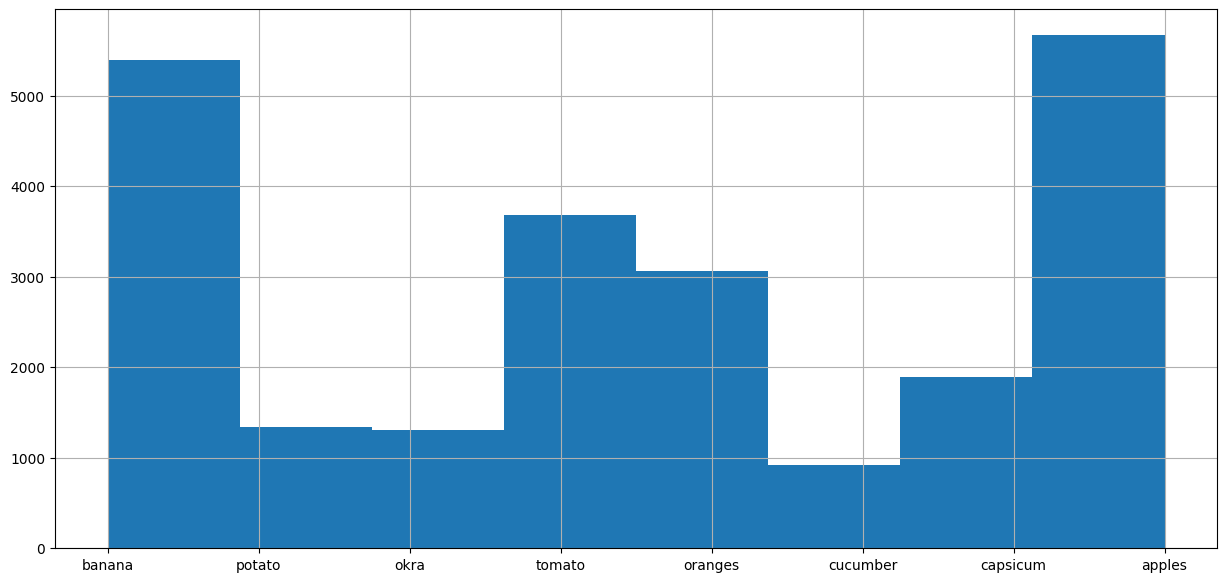

In [103]:
df[df['split']=='Train']['class'].hist(figsize=(15,7), bins=8)

In [105]:
cls_th = 1500
df.sample(frac=1)

for cls in set(df['class'].values):
    num_cls = len(df[(df['class']==cls) & (df['split']=='Train')])
    if not num_cls == cls_th:
        if num_cls>cls_th: 
            df.drop(index=df[(df['class']==cls)&(df['split']=='Train')].index[:int(num_cls-cls_th)], inplace=True)
            df.reset_index(inplace=True, drop=True)
        else:
            df = pd.concat([df, df[(df['class']==cls)&(df['split']=='Train')].iloc[:int(cls_th-num_cls)]], ignore_index=True)
            df.reset_index(inplace=True, drop=True)
        
df[df['split']=='Train']['class'].value_counts()

class
potato      1500
okra        1500
oranges     1500
cucumber    1500
capsicum    1500
tomato      1500
banana      1500
apples      1500
Name: count, dtype: int64

In [106]:
val_cls_th = 250
df.sample(frac=1)

for cls in set(df['class'].values):
    num_cls = len(df[(df['class']==cls) & (df['split']=='Test')])
    if not num_cls == val_cls_th:
        if num_cls>val_cls_th:
            df.drop(index=df[(df['class']==cls)&(df['split']=='Test')].index[:int(num_cls-val_cls_th)], inplace=True)
            df.reset_index(inplace=True, drop=True)
        else:
            df = pd.concat([df, df[(df['class']==cls)&(df['split']=='Test')].iloc[:int(cls_th-val_cls_th)]], ignore_index=True)
            df.reset_index(inplace=True, drop=True)
        
df[df['split']=='Test']['class'].value_counts()

class
okra        250
oranges     250
banana      250
cucumber    250
potato      250
apples      250
tomato      250
Name: count, dtype: int64

In [107]:
df = df.sample(frac=1)

In [108]:
train_df = df[df['split']=='Train'].copy()
val_df = df[df['split']=='Test'].copy()

In [109]:
from sklearn import preprocessing 
label_encoder = preprocessing.LabelEncoder() 
  
train_df['class']= label_encoder.fit_transform(train_df['class']) 
val_df['class']= label_encoder.transform(val_df['class']) 

In [111]:
class config:
    seed=42
    bs = 32 # batch size
    lr = 0.001
    epochs = 5
    height = 300
    width = 300
    channels = 3
    num_classes = 10
    alpha = 0.4, # ürün sınıflaması --> multi class (0,1,2,...)
    beta = 0.6 # durum sınıflaması --> binary (0,1)

In [114]:
train_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255., 
    rotation_range=30,
    shear_range=0.1,
    zoom_range=0.2,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True
)

val_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255.
)

train_data_generator = train_data_gen.flow_from_dataframe(train_df,
                                         directory=ds_train_dir,
                                         x_col='img_path',
                                         y_col=['class', 'status'],
                                         batch_size=config.bs,
                                         class_mode='multi_output',
                                         target_size=(config.height,config.width),
                                         seed=config.seed,
                                         shuffle=True)
val_data_generator = val_data_gen.flow_from_dataframe(val_df,
                                       directory=ds_test_dir,
                                       x_col='img_path',
                                       y_col=['class', 'status'],
                                       batch_size=config.bs,
                                       class_mode='multi_output',
                                       target_size=(config.height,config.width),
                                       seed=config.seed)

Found 12000 validated image filenames.
Found 1750 validated image filenames.


class : freshtomato
shape : (512, 512, 3)


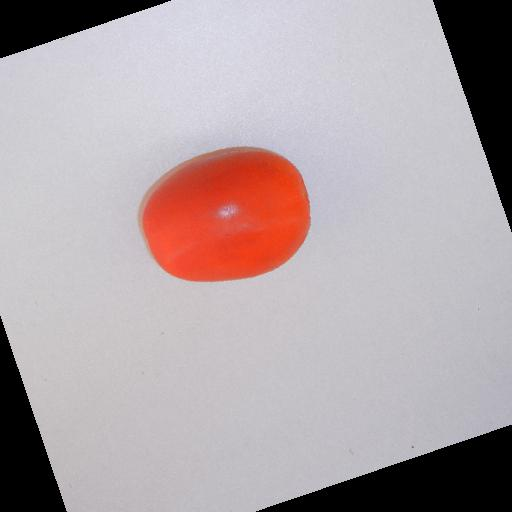

In [29]:
ext_ = random.choice(extentions)
path = random.choice(list(ds_train_dir.glob('*/*.' + ext_)))
img = Image.open(str(path))
print(f'class : {str(path).split(os.sep)[-2]}')
print(f'shape : {np.array(img).shape}')
img

In [30]:
class GaussianFilter(tf.keras.layers.Layer):
    def __init__(self,kernel_size=3):
        super(GaussianFilter, self).__init__()
        self.kernel_size = kernel_size
    def call(self, inputs, training=True):
        if training:
            return tfio.experimental.filter.gaussian(inputs, ksize=self.kernel_size, sigma=(0.1, 2.0))
        else:
            return inputs
    def compute_output_shape(self, input_shape):
        return input_shape
    
gaussian_filter_layer = GaussianFilter()
x = tf.random.uniform((2,300,300,3))
gaussian_filter_layer(x).shape

TensorShape([2, 300, 300, 3])

In [53]:
resnet50V2 = tf.keras.applications.ResNet50V2(include_top=False, pooling='avg')

In [ ]:
len(resnet50V2.layers)

In [55]:
for layer in resnet50V2.layers[:-20]:
    layer.trainable = False

In [116]:
backbone_layer = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    GaussianFilter(),
    resnet50V2
])

In [117]:
backbone_inputs = tf.keras.layers.Input(shape=(config.height, config.width, config.channels))

backbone_layer_out = backbone_layer(backbone_inputs)

backbone_model = tf.keras.Model(inputs=backbone_inputs,
                                outputs=backbone_layer_out)

In [127]:
ic_block = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.15), # overfitting i engellemek için
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(config.num_classes, activation='softmax')
])

ic_model_inp = tf.keras.layers.Input(shape=backbone_model.output.shape[1:])

ic_model_out = ic_block(ic_model_inp)

ic_model = tf.keras.Model(inputs=ic_model_inp,
                          outputs=ic_model_out)

In [128]:
rotten_block = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.15), # overfitting i engellemek için
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

rotten_model_inp = tf.keras.layers.Input(shape=backbone_model.output.shape[1:])

rotten_model_out = rotten_block(rotten_model_inp)

rotten_model = tf.keras.Model(inputs=rotten_model_inp,
                              outputs=rotten_model_out)

In [129]:
ic_optimizer = tf.keras.optimizers.Adam(learning_rate=config.lr)
rotten_optimizer = tf.keras.optimizers.Adam(learning_rate=config.lr)
backbone_optimizer = tf.keras.optimizers.Adam(learning_rate=config.lr)

ic_model_loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
rotten_model_loss_fn = tf.keras.losses.BinaryCrossentropy()

In [121]:
acc = tf.keras.metrics.Accuracy()

In [130]:
@tf.function
def train_step(x_batch_train, y_batch_train):
    with tf.device('/GPU:0'):
        with tf.GradientTape(persistent=True) as tape:
            
            logits = backbone_model(x_batch_train, training=True)
            ic_logits = ic_model(logits, training=True)
            rotten_logits = rotten_model(logits, training=True)

            ic_loss_value = ic_model_loss_fn(tf.expand_dims(y_batch_train[0], axis=-1), ic_logits)
            rotten_loss_value = rotten_model_loss_fn(tf.expand_dims(y_batch_train[1], axis=-1), rotten_logits)
            backbone_loss_value = config.alpha * ic_loss_value + config.beta * rotten_loss_value

        ic_grads = tape.gradient(ic_loss_value, ic_model.trainable_weights)
        rotten_grads = tape.gradient(rotten_loss_value, rotten_model.trainable_weights)
        backbone_grads = tape.gradient(backbone_loss_value, backbone_model.trainable_weights)
        
        ic_optimizer.apply_gradients(zip(ic_grads, ic_model.trainable_weights))
        rotten_optimizer.apply_gradients(zip(rotten_grads, rotten_model.trainable_weights))
        backbone_optimizer.apply_gradients(zip(backbone_grads, backbone_model.trainable_weights))
        
        del tape

In [ ]:
for epoch in range(config.epochs):
    print("\nStart of epoch %d" % (epoch,))

    train_loss = []
    ic_acc = []
    rotten_acc = []

    for _ in tqdm(range(len(train_df)//config.bs)):
        
        x_batch_train, y_batch_train = next(iter(train_data_generator))
        
        train_step(x_batch_train, y_batch_train)
        
        logits = backbone_model(x_batch_train, training=True)

        ic_logits = ic_model(logits, training=True)
        rotten_logits = rotten_model(logits, training=True)

        ic_loss_value = ic_model_loss_fn(tf.expand_dims(y_batch_train[0], axis=-1), ic_logits)
        rotten_loss_value = rotten_model_loss_fn(tf.expand_dims(y_batch_train[1], axis=-1), rotten_logits)
        backbone_loss_value = config.alpha * ic_loss_value + config.beta * rotten_loss_value
        
        train_loss.append(backbone_loss_value)
        
        acc.reset_state()
        acc.update_state(tf.expand_dims(y_batch_train[0], axis=-1), tf.argmax(ic_logits, axis=-1))
        ic_acc.append(acc.result().numpy())

        acc.reset_state()
        acc.update_state(tf.expand_dims(y_batch_train[1], axis=-1), tf.round(rotten_logits))
        rotten_acc.append(acc.result().numpy())
        
    print('evaluating the model...')
    
    test_loss = []
    test_ic_acc = []
    test_rotten_acc = []
    
    for _ in tqdm(range((len(val_df)//config.bs)//2)):
        
        x_batch_test, y_batch_test = next(iter(val_data_generator))

        logits = backbone_model(x_batch_test, training=False)
        ic_logits = ic_model(logits, training=False)
        rotten_logits = rotten_model(logits, training=False)

        ic_loss_value = ic_model_loss_fn(tf.expand_dims(y_batch_test[0], axis=-1), ic_logits)
        rotten_loss_value = rotten_model_loss_fn(tf.expand_dims(y_batch_test[1], axis=-1), rotten_logits)
        backbone_loss_value = config.alpha * ic_loss_value + config.beta * rotten_loss_value
            
        test_loss.append(backbone_loss_value)
        
        acc.reset_state()
        acc.update_state(tf.expand_dims(y_batch_test[0], axis=-1), tf.argmax(ic_logits, axis=-1))
        test_ic_acc.append(acc.result().numpy())
        
        acc.reset_state()
        acc.update_state(tf.expand_dims(y_batch_test[1], axis=-1), tf.round(rotten_logits))
        test_rotten_acc.append(acc.result().numpy())

    print(
        f"epoch : {epoch} / train_loss : {tf.reduce_mean(tf.convert_to_tensor(train_loss))} / train_ic_acc : {tf.reduce_mean(tf.convert_to_tensor(ic_acc))} / train_rotten_acc : {tf.reduce_mean(tf.convert_to_tensor(rotten_acc))}"
    )
    print(
        f"test_loss : {tf.reduce_mean(tf.convert_to_tensor(test_loss))} / test_ic_acc : {tf.reduce_mean(tf.convert_to_tensor(test_ic_acc))} / test_rotten_acc : {tf.reduce_mean(tf.convert_to_tensor(test_rotten_acc))}"
    )
    print('-'*100)


Start of epoch 0


100%|██████████| 375/375 [08:36<00:00,  1.38s/it]


evaluating the model...


100%|██████████| 27/27 [00:12<00:00,  2.08it/s]


epoch : 0 / train_loss : 0.231833353638649 / train_ic_acc : 0.9104166626930237 / train_rotten_acc : 0.9179166555404663
test_loss : 0.3187083899974823 / test_ic_acc : 0.8982533812522888 / test_rotten_acc : 0.9028830528259277
----------------------------------------------------------------------------------------------------

Start of epoch 1


100%|██████████| 375/375 [08:21<00:00,  1.34s/it]


evaluating the model...


100%|██████████| 27/27 [00:12<00:00,  2.23it/s]


epoch : 1 / train_loss : 0.12438398599624634 / train_ic_acc : 0.9587500095367432 / train_rotten_acc : 0.9559999704360962
test_loss : 0.13670989871025085 / test_ic_acc : 0.9606481194496155 / test_rotten_acc : 0.9398148059844971
----------------------------------------------------------------------------------------------------

Start of epoch 2


  3%|▎         | 10/375 [00:13<08:00,  1.32s/it]